In [30]:
import torch
import sys
import numpy as np
sys_path = 'D:/Research_CAE/MyTinyCUDANN/tiny-cuda-nn/main'
sys.path.append(sys_path)
from PDE import Wave_equation, Helmholtz_equation
from matplotlib import pyplot as plt
device = "cpu" #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

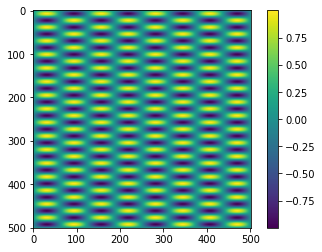

In [31]:
c = 10.0
# equation = Wave_equation(c= c)
equation = Helmholtz_equation()
# equation = Gordon_equation()
# generate grid points for [0,1] * [0,1]
field_min = -1
field_max = 1
resolution = 501
x1_list = np.linspace(field_min, field_max, resolution)
x2_list = np.linspace(field_min, field_max, resolution)
X1,X2 = np.meshgrid(x1_list,x2_list)
X_field = torch.tensor(np.concatenate((X1.reshape(-1,1),X2.reshape(-1,1)),axis = 1)).float().to(device)
real_solution = equation.real_solution(X_field)
real_solution = real_solution.reshape(resolution,resolution)
plt.imshow(real_solution)
plt.colorbar()

In [6]:
pred = np.loadtxt("D:\\Research_CAE\\MyTinyCUDANN\\tiny-cuda-nn\\main\\Wave_equation\\Tasks\\GridMLP_decoupled\\config_1\\pred_0.txt")
pred = pred.reshape(501,501)
plt.imshow(pred)
plt.colorbar()

OSError: D:\Research_CAE\MyTinyCUDANN\tiny-cuda-nn\main\Wave_equation\Tasks\GridMLP_decoupled\config_1\pred_0.txt not found.

In [32]:
from torch.autograd import grad

In [34]:
X = torch.tensor([[0.4,0.3]], requires_grad=True)
u = equation.real_solution(X)
grad_u = grad(u,X,torch.ones(1),retain_graph=True, create_graph=True)[0]
u_t,u_x = grad_u[:,0],grad_u[:,1]
grad_u_x = grad(u_x,X,torch.ones(1),retain_graph=True, create_graph=True)[0]
u_xx = grad_u_x[:,1]
grad_u_t = grad(u_t,X,torch.ones(1),retain_graph=True, create_graph=True)[0]
u_tt = grad_u_t[:,0]
equation.strong_form(X,{"u":u,"d2u_dx2": u_tt, "d2u_dy2": u_xx})

tensor([0.0001], grad_fn=<SubBackward0>)

In [55]:
X_field.requires_grad = True
solution =  equation.real_solution(X_field) #* X_field[:, 0] - 100
grad_u = grad(solution,X_field,torch.ones(X_field.shape[0]),retain_graph=True, create_graph=True)[0]
u_t,u_x = grad_u[:,0],grad_u[:,1]
# (u_t**2 - u_x**2).mean()
# equation.variational_energy(X_field,u,u_t,u_x).mean()
u_t, u_x

(tensor([-1.7577e-05, -1.7555e-05, -1.7489e-05,  ...,  1.7489e-05,
          1.7555e-05,  1.7577e-05], grad_fn=<SelectBackward0>),
 tensor([-1.7577e-05,  2.5255e+00,  5.0447e+00,  ..., -5.0447e+00,
         -2.5255e+00,  1.7577e-05], grad_fn=<SelectBackward0>))

In [56]:
equation.variational_energy(X_field,solution,u_t,u_x).mean()

tensor(-332.7669, grad_fn=<MeanBackward0>)

In [15]:
class Gordon_equation(torch.nn.Module):
    def __init__(self,m = 1.0, lam = 1.0):
        super().__init__()
        self.m = m
        self.m2 = m**2
        self.lam = lam
        self.const = np.sqrt(self.m2/self.lam)
    def strong_form(self,grad_result):
        u,d2u_dt2,d2u_dx2 = grad_result["u"],grad_result["d2u_dx2"],grad_result["d2u_dy2"]
        result = d2u_dt2 - d2u_dx2 + self.m2 * u + self.lam * u**3
        return result
    def variational_energy(self,X,u,du_dt,du_dx):
        result = 0.5*(du_dt**2 - du_dx**2 - self.m2*u**2 - 0.5*self.lam*u**4)
        return result
    def BC_function(self,X):
        return self.real_solution(X)
    def real_solution(self,X):
        return self.const * torch.tanh(self.m/np.sqrt(2.0)*X[:,1])